# Tomato disease classifier

This notebook is about building a tomato disease classifier that can be used to identify the possible disseases of your tomato using an image

In [1]:


# # downloaded the dataset:
# !curl -L -o /content/tomato-disease-multiple-sources.zip https://www.kaggle.com/api/v1/datasets/download/cookiefinder/tomato-disease-multiple-sources

# # Unzip the file
# !unzip /content/tomato-disease-multiple-sources.zip -d /content/tomato-disease-dataset

# # Remove the zip file
# !rm /content/tomato-disease-multiple-sources.zip

# import os

# # Change the working directory
# os.chdir('/content/tomato-disease-dataset')

# # Verify the change
# print(os.getcwd())


In [2]:
#importing required libraries for the job

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

import matplotlib.pyplot as plt
import numpy as np



In [3]:
# Check if any GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# If a CUDA device is available, use the first available GPU
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # Using the first available GPU at index 0
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda:0


In [4]:
global IMAGE_SIZE, BATCH_SIZE, CHANNELS, NUM_CLASSES, EPOCH
IMAGE_SIZE = 256
BATCH_SIZE = 16
CHANNELS = 3
EPOCH = 80

In [5]:
#defining the path of the dateset
data_path = '/kaggle/input/tomato-disease-multiple-sources/train' #/content/tomato-disease-dataset/train

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # Making sure that the size is fixed for all
    transforms.ToTensor(), # Convert to tensor
])

#Load dataset from directory
dataset = ImageFolder(root=data_path, transform=transform)

# Create DataLoader with batching
data_loader = DataLoader(dataset, batch_size= BATCH_SIZE, shuffle=True,
                          num_workers=4,               # Number of workers for data loading
                          pin_memory=True,             # Use pinned memory for GPU transfer
                          prefetch_factor=2,            # Number of batches to prefetch per workers
                          persistent_workers=True      # Keep workers alive between epochs
                         )




In [6]:
CLASSES = dataset.classes
NUM_CLASSES = len(CLASSES)
print(NUM_CLASSES)

# View class names (subfolder names)
print("Class Names:")
for class_name in dataset.classes:
    print(class_name)

# View class-to-index mapping
print("\nClass-to-Index Mapping:")
for class_name, index in dataset.class_to_idx.items():
    print(f"{index}: {class_name}")

# View total number of samples
print("\nNumber of images:", len(dataset))

# View a single sample (image and label)
img1, label1 = dataset[0]  # Access the first sample
print("Image shape:", img1.shape)  # Shape of the image tensor
print("Label:", label1)  # Integer label corresponding to the class

11
Class Names:
Bacterial_spot
Early_blight
Late_blight
Leaf_Mold
Septoria_leaf_spot
Spider_mites Two-spotted_spider_mite
Target_Spot
Tomato_Yellow_Leaf_Curl_Virus
Tomato_mosaic_virus
healthy
powdery_mildew

Class-to-Index Mapping:
0: Bacterial_spot
1: Early_blight
2: Late_blight
3: Leaf_Mold
4: Septoria_leaf_spot
5: Spider_mites Two-spotted_spider_mite
6: Target_Spot
7: Tomato_Yellow_Leaf_Curl_Virus
8: Tomato_mosaic_virus
9: healthy
10: powdery_mildew

Number of images: 25851
Image shape: torch.Size([3, 256, 256])
Label: 0


In [7]:
num = len(data_loader)
print(num)

1616


In [8]:
print(num*32) #Matches the number of batches we have created and the number of images we have got


51712


In [9]:
for images, labels in data_loader:
    print(images.shape)
    print(labels.numpy())
    break

torch.Size([16, 3, 256, 256])
[ 9  0  7  9  9  8  4  5  7 10  0  6  7  9  0  2]


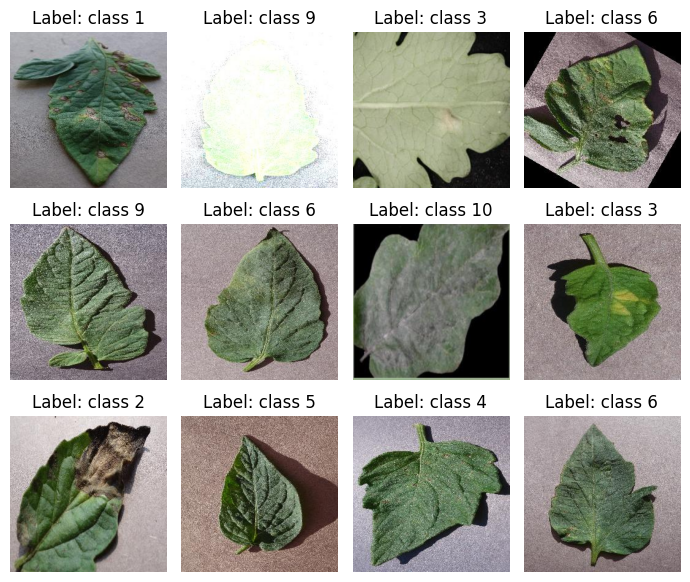

In [10]:
#for a singular image
for images, labels in data_loader:
  fig, axes = plt.subplots(3, 4, figsize=(7, 6)) 

  # Plot the first 12 images
  for i in range(12):
      row, col = divmod(i, 4)  
      ax = axes[row, col]
      ax.imshow(images[i].permute(1, 2, 0))  # Change from C x H x W to H x W x C)
      ax.set_title(f"Label: class {labels[i].item()}")
      ax.axis('off')  # Turn off axes

  plt.tight_layout()
  plt.show()
  break

In [29]:
#defining the path of the valid and test dateset
valid_data_path = '/kaggle/input/tomato-disease-multiple-sources/valid' #'/content/tomato-disease-dataset/valid'

# Define the transformation
valid_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # Making sure that the size is fixed for all
    transforms.ToTensor(),                       # Convert to tensor
])

# Load dataset from directory
valid_dataset = ImageFolder(root=valid_data_path, transform=valid_transform)

# Define the split sizes
valid_size = int(0.5 * len(valid_dataset))  # 50% for validation
test_size = len(valid_dataset) - valid_size  # Remaining for test

# Split the dataset
valid_subset, test_subset = random_split(valid_dataset, [valid_size, test_size])

# Create DataLoaders for validation and test sets
# Set a seed for reproducibility
torch.manual_seed(42)
valid_loader = DataLoader(valid_subset, batch_size= BATCH_SIZE, shuffle=True,
                           num_workers=4,               # Number of workers for data loading
                           pin_memory=True,             # Use pinned memory for GPU transfer
                           prefetch_factor=2,            # Number of batches to prefetch per workers
                           persistent_workers=True      # Keep workers alive between epochs
                         )



# Set a seed for reproducibility
torch.manual_seed(42)
test_loader = DataLoader(test_subset,  batch_size= BATCH_SIZE, shuffle=True,
                           num_workers=4,               # Number of workers for data loading
                           pin_memory=True,             # Use pinned memory for GPU transfer
                           prefetch_factor=2,            # Number of batches to prefetch per workers
                           persistent_workers=True      # Keep workers alive between epochs
                         )





In [12]:
# Check the size of SETS
print(f"Training set size: {len(data_loader)}")
print(f"Validation set size: {len(valid_loader)}")
print(f"Test set size: {len(test_loader)}")

Training set size: 1616
Validation set size: 209
Test set size: 209


torch.Size([3, 256, 256])
5


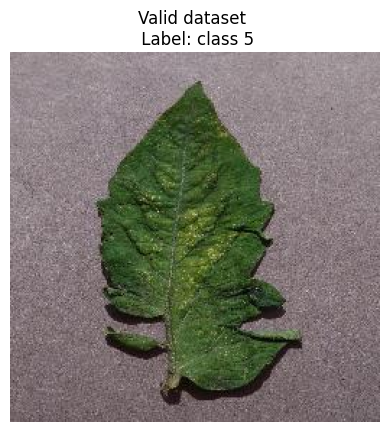

In [13]:
#Checking whether the datasets are fine
for images, labels in valid_loader:
    print(images[0].shape)
    print(labels[0].numpy())
    plt.imshow(images[0].permute(1, 2, 0))  # Change from C x H x W to H x W x C)
    plt.title(f"Valid dataset \n Label: class {labels[0]}")
    plt.axis('off')
    plt.show()
    break

torch.Size([3, 256, 256])
7


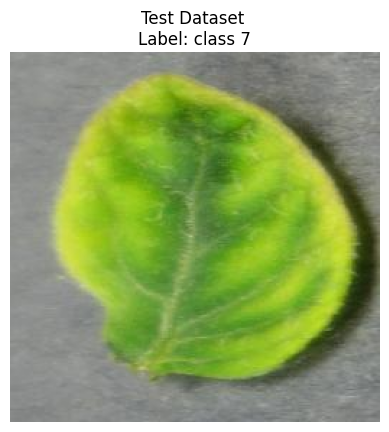

In [14]:
for images, labels in test_loader:
    print(images[0].shape)
    print(labels[0].numpy())
    plt.imshow(images[0].permute(1, 2, 0))  # Change from C x H x W to H x W x C)
    plt.title(f"Test Dataset \nLabel: class {labels[0]}")
    plt.axis('off')
    plt.show()
    break

In [15]:
# For scaling and resizing incase external images are used
class ScaleAndResizeLayer(nn.Module):
    def __init__(self, size=(IMAGE_SIZE, IMAGE_SIZE), scale=1.0/255.0):
        super(ScaleAndResizeLayer, self).__init__()
        self.resize = T.Resize(size)  # Resize to the target size
        self.scale = scale           # Scale factor

    def forward(self, x):
        # Resize and scale
        x = self.resize(x)
        x = x * self.scale  # Scale the pixel values
        return x

In [16]:
#Augmenting the input the data for better modelling
class AugmentationLayer(nn.Module):
    def __init__(self, image_size=(IMAGE_SIZE, IMAGE_SIZE)):
        super(AugmentationLayer, self).__init__()
        self.augmentations = T.Compose([
            T.RandomHorizontalFlip(p=0.5),            # 50% chance of horizontal flip
            T.RandomRotation(degrees=30),            # Random rotation within ±30 degrees
            T.Resize(image_size),                    # Resize to the target size
            T.RandomCrop(image_size),                # Optional: Random crop
            T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color jitter
        ])

    def forward(self, x):
        # Apply augmentations
        return self.augmentations(x)

In [17]:
#Building the CNN -based model now


class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.model = nn.Sequential(
            # Preprocessing and augmentation layers
            ScaleAndResizeLayer(),                                 # Scaling and Resizing layer
            AugmentationLayer(),                                   # Augmentation layer

            # First convolution block
            nn.Conv2d(3, 32, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Additional convolution blocks
            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Flatten layer
            nn.Flatten(),

            # Fully connected (dense) layer
            nn.Linear(64 * 4 * 4, 64),  # Adjust input features based on the final dimensions
            nn.ReLU(),

            # Final classification layer
            nn.Linear(64, NUM_CLASSES),  # Final layer with number of neurons equal to number of classes
            nn.Softmax(dim=1)              # Softmax for multi-class classification
        )

    def forward(self, x):
        assert x.shape[1:] == (3, 256, 256), f"Expected (3, 256, 256), got {x.shape[1:]}"  # Check input shape
        return self.model(x)




In [18]:
!pip install torchsummary # Install the torchsummary package

#Printing a summary of the built model

from torchsummary import summary

model = MyModel()
model.to(device)
summary(model, input_size=(3, 256, 256))  # (Channels, Height, Width)



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Resize-1          [-1, 3, 256, 256]               0
ScaleAndResizeLayer-2          [-1, 3, 256, 256]               0
 AugmentationLayer-3          [-1, 3, 256, 256]               0
            Conv2d-4         [-1, 32, 256, 256]             896
              ReLU-5         [-1, 32, 256, 256]               0
         MaxPool2d-6         [-1, 32, 128, 128]               0
            Conv2d-7         [-1, 64, 128, 128]          18,496
              ReLU-8         [-1, 64, 128, 128]               0
         MaxPool2d-9           [-1, 64, 64, 64]               0
           Conv2d-10           [-1, 64, 64, 64]          36,928
             ReLU-11           [-1, 64, 64, 64]               0
        MaxPool2d-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,928
             ReLU-14           [-1, 64

In [19]:
'''
This model in it self when trained results in very low accuracies.
Hence, I thought of initiationg with pre trained weights to have a better chgen of having a good accuracy

'''

# def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
#     """
#     Trains and validates a PyTorch model, similar to model.fit in Keras.

#     Args:
#         model: The PyTorch model to train.
#         train_loader: DataLoader for training data.
#         val_loader: DataLoader for validation data.
#         criterion: Loss function.
#         optimizer: Optimizer.
#         num_epochs: Number of epochs to train.
#         device: Device to run the model on ('cpu' or 'cuda').

#     Returns:
#         Trained model.
#     """
#     for epoch in range(num_epochs):
#         # Training phase
#         model.train()  # Set model to training mode
#         train_loss = 0.0
#         train_correct = 0
#         train_total = 0

#         for inputs, labels in train_loader:
#             inputs, labels = inputs.to(device), labels.to(device)

#             # Zero the parameter gradients
#             optimizer.zero_grad()

#             # Forward pass
#             outputs = model(inputs)

#             # Compute loss
#             loss = criterion(outputs, labels)

#             # Backward pass and optimization
#             loss.backward()
#             optimizer.step()

#             # Accumulate loss and metrics
#             train_loss += loss.item() * inputs.size(0)
#             train_correct += (outputs.argmax(1) == labels).sum().item()
#             train_total += labels.size(0)

#         # Calculate average training loss and accuracy
#         avg_train_loss = train_loss / train_total
#         train_accuracy = train_correct / train_total

#         # Validation phase
#         model.eval()  # Set model to evaluation mode
#         val_loss = 0.0
#         val_correct = 0
#         val_total = 0

#         with torch.no_grad():
#             for inputs, labels in val_loader:
#                 inputs, labels = inputs.to(device), labels.to(device)

#                 # Forward pass
#                 outputs = model(inputs)

#                 # Compute loss
#                 loss = criterion(outputs, labels)

#                 # Accumulate loss and metrics
#                 val_loss += loss.item() * inputs.size(0)
#                 val_correct += (outputs.argmax(1) == labels).sum().item()
#                 val_total += labels.size(0)

#         # Calculate average validation loss and accuracy
#         avg_val_loss = val_loss / val_total
#         val_accuracy = val_correct / val_total

#         # Print progress for the current epoch
#         print(f"Epoch {epoch+1}/{num_epochs}")
#         print(f"  Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
#         print(f"  Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

#     return model




'\nThis model in it self when trained results in very low accuracies.\nHence, I thought of initiationg with pre trained weights to have a better chgen of having a good accuracy\n\n'

In [23]:
from tqdm.notebook import tqdm
import gc
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

class EarlyStopping:
    def __init__(self, patience=7, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = model.state_dict().copy()
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            self.status = f'EarlyStopping counter: {self.counter} out of {self.patience}'
            if self.counter >= self.patience:
                self.status = f'EarlyStopping triggered after {self.counter} epochs'
                return True
        else:
            self.best_loss = val_loss
            self.best_model = model.state_dict().copy()
            self.counter = 0
            self.status = 'Improved'
        return False

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device,
                scheduler=None, early_stopping_patience=5):
    """
    Trains and validates a PyTorch model with Colab-optimized features.

    Args:
        model: The PyTorch model to train
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        criterion: Loss function
        optimizer: Optimizer
        num_epochs: Number of epochs to train
        device: Device to run the model on ('cpu' or 'cuda')
        scheduler: Optional learning rate scheduler
        early_stopping_patience: Number of epochs to wait before early stopping

    Returns:
        Trained model and dictionary containing training history
    """
    # Initialize early stopping
    early_stopping = EarlyStopping(patience=early_stopping_patience)

    # Initialize history dictionary
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': []
    }

    # Get the start time
    start_time = datetime.now()

    print(f"Training started at {start_time.strftime('%H:%M:%S')}")
    print(f"Using device: {device}")

    try:
        for epoch in range(num_epochs):
            # Training phase
            model.train()
            train_loss = 0.0
            train_correct = 0
            train_total = 0

            # Use tqdm for progress bar
            train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')

            for inputs, labels in train_pbar:
                inputs, labels = inputs.to(device), labels.to(device)

                # Clear gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Backward pass and optimization
                loss.backward()
                optimizer.step()

                # Accumulate metrics
                train_loss += loss.item() * inputs.size(0)
                train_correct += (outputs.argmax(1) == labels).sum().item()
                train_total += labels.size(0)

                # Update progress bar
                train_pbar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'acc': f'{train_correct/train_total:.4f}'
                })

            # Validation phase
            model.eval()
            val_loss = 0.0
            val_correct = 0
            val_total = 0

            val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Valid]')

            with torch.no_grad():
                for inputs, labels in val_pbar:
                    inputs, labels = inputs.to(device), labels.to(device)

                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    val_loss += loss.item() * inputs.size(0)
                    val_correct += (outputs.argmax(1) == labels).sum().item()
                    val_total += labels.size(0)

                    val_pbar.set_postfix({
                        'loss': f'{loss.item():.4f}',
                        'acc': f'{val_correct/val_total:.4f}'
                    })

            # Calculate epoch metrics
            avg_train_loss = train_loss / train_total
            avg_val_loss = val_loss / val_total
            train_accuracy = train_correct / train_total
            val_accuracy = val_correct / val_total

            # Update history
            history['train_loss'].append(avg_train_loss)
            history['val_loss'].append(avg_val_loss)
            history['train_acc'].append(train_accuracy)
            history['val_acc'].append(val_accuracy)

            # Print epoch summary
            print(f"\nEpoch {epoch+1}/{num_epochs} Summary:")
            print(f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}")
            print(f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

            # Learning rate scheduler step
            if scheduler is not None:
                scheduler.step()
                print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

            # Early stopping check
            if early_stopping(avg_val_loss, model):
                print("Early stopping triggered!")
                model.load_state_dict(early_stopping.best_model)
                break

            # Clear GPU memory
            torch.cuda.empty_cache()
            gc.collect()

    except KeyboardInterrupt:
        print("\nTraining interrupted by user!")
        if early_stopping.best_model is not None:
            print("Loading best model weights...")
            model.load_state_dict(early_stopping.best_model)

    # Calculate training time
    training_time = datetime.now() - start_time
    print(f"\nTraining completed in {training_time}")

    return model, history

# Initialize model, criterion, and optimizer with improved settings for Colab
def initialize_training(model, learning_rate=1e-4):
    """
    Initialize training components with Colab-optimized settings
    """
    # Move model to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Use mixed precision for faster training
    scaler = torch.cuda.amp.GradScaler()

    # Loss function with label smoothing for better generalization
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    # AdamW optimizer with weight decay
    optimizer = torch.optim.AdamW(model.parameters(),
                                lr=learning_rate,
                                weight_decay=0.01)

    # Cosine annealing scheduler with warm restarts
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer,
        T_0=10,  # Reset LR every 10 epochs
        T_mult=2,  # Double the reset interval after each restart
        eta_min=1e-6  # Minimum learning rate
    )

    return device, criterion, optimizer, scheduler, scaler

In [24]:
class PretrainedClassifier(nn.Module):
    def __init__(self, num_classes, model_name='resnet50', freeze_backbone=True):
        """
        Initialize model with pre-trained backbone

        Args:
            num_classes: Number of classes to predict
            model_name: Name of the pre-trained model to use
            freeze_backbone: Whether to freeze the backbone layers
        """
        super(PretrainedClassifier, self).__init__()

        # Available pretrained models
        self.available_models = {
            'resnet18': models.resnet18,
            'resnet50': models.resnet50,
            'efficientnet_b0': models.efficientnet_b0,
            'mobilenet_v3_large': models.mobilenet_v3_large,
            'convnext_small': models.convnext_small
        }

        if model_name not in self.available_models:
            raise ValueError(f"Model {model_name} not available. Choose from: {list(self.available_models.keys())}")

        # Load pretrained model
        self.backbone = self.available_models[model_name](pretrained=True)

        # Freeze backbone if specified
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False

        # Replace the final layer based on model type
        if model_name.startswith('resnet'):
            in_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Sequential(
                nn.Linear(in_features, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(512, num_classes)
            )
        elif model_name.startswith('efficientnet'):
            in_features = self.backbone.classifier[-1].in_features
            self.backbone.classifier = nn.Sequential(
                nn.Linear(in_features, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(512, num_classes)
            )
        elif model_name.startswith('mobilenet'):
            in_features = self.backbone.classifier[-1].in_features
            self.backbone.classifier = nn.Sequential(
                nn.Linear(in_features, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(512, num_classes)
            )
        elif model_name.startswith('convnext'):
            in_features = self.backbone.classifier[-1].in_features
            self.backbone.classifier = nn.Sequential(
                nn.Linear(in_features, 512),
                nn.LayerNorm(512),
                nn.GELU(),
                nn.Dropout(0.3),
                nn.Linear(512, num_classes)
            )

    def forward(self, x):
        return self.backbone(x)

def initialize_training_pretrained(model, num_epochs, train_loader, learning_rate=1e-4):
    """
    Initialize training components optimized for fine-tuning
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Different learning rates for pretrained and new layers
    params = [
        {'params': [p for n, p in model.named_parameters() if 'backbone' not in n or 'fc' in n or 'classifier' in n],
         'lr': learning_rate},
        {'params': [p for n, p in model.named_parameters() if 'backbone' in n and 'fc' not in n and 'classifier' not in n],
         'lr': learning_rate/10}
    ]

    # Optimizer with weight decay
    optimizer = torch.optim.AdamW(params, weight_decay=0.01)

    # Loss function with label smoothing
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=[learning_rate, learning_rate/10],
        epochs=num_epochs,
        steps_per_epoch=len(train_loader),
        pct_start=0.3,
        anneal_strategy='cos'
    )

    # Gradient scaler for mixed precision training
    scaler = torch.cuda.amp.GradScaler()

    return device, criterion, optimizer, scheduler, scaler

In [25]:
# Creating a model with pretrained weights

model = PretrainedClassifier(
    num_classes= NUM_CLASSES,
    model_name='resnet50', 
    freeze_backbone=True    # freeze pretrained weights initially
)

# Initialize training components
device, criterion, optimizer, scheduler, scaler = initialize_training_pretrained(
    model,
    num_epochs=EPOCH,
    train_loader=data_loader,
    learning_rate=1e-4
)



# Train as before
trained_model, history = train_model(
    model=model,
    train_loader=data_loader,
    val_loader=valid_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=EPOCH,
    device=device,
    scheduler=scheduler,
    early_stopping_patience=5
)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 223MB/s]


Training started at 03:22:11
Using device: cuda


Epoch 1/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 1/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 1/80 Summary:
Train Loss: 1.8778, Train Acc: 0.4621
Val Loss: 1.4052, Val Acc: 0.7316
Learning Rate: 0.000004


Epoch 2/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 2/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 2/80 Summary:
Train Loss: 1.3769, Train Acc: 0.7012
Val Loss: 1.1670, Val Acc: 0.7944
Learning Rate: 0.000004


Epoch 3/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 3/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 3/80 Summary:
Train Loss: 1.2182, Train Acc: 0.7473
Val Loss: 1.0679, Val Acc: 0.8181
Learning Rate: 0.000004


Epoch 4/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 4/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 4/80 Summary:
Train Loss: 1.1421, Train Acc: 0.7719
Val Loss: 1.0161, Val Acc: 0.8303
Learning Rate: 0.000004


Epoch 5/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 5/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 5/80 Summary:
Train Loss: 1.0902, Train Acc: 0.7907
Val Loss: 0.9650, Val Acc: 0.8534
Learning Rate: 0.000004


Epoch 6/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 6/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 6/80 Summary:
Train Loss: 1.0541, Train Acc: 0.8029
Val Loss: 0.9376, Val Acc: 0.8606
Learning Rate: 0.000004


Epoch 7/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 7/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 7/80 Summary:
Train Loss: 1.0258, Train Acc: 0.8164
Val Loss: 0.9186, Val Acc: 0.8698
Learning Rate: 0.000004


Epoch 8/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 8/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 8/80 Summary:
Train Loss: 1.0080, Train Acc: 0.8214
Val Loss: 0.9115, Val Acc: 0.8645
Learning Rate: 0.000004


Epoch 9/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 9/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 9/80 Summary:
Train Loss: 0.9883, Train Acc: 0.8296
Val Loss: 0.8950, Val Acc: 0.8749
Learning Rate: 0.000004


Epoch 10/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 10/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 10/80 Summary:
Train Loss: 0.9719, Train Acc: 0.8359
Val Loss: 0.8853, Val Acc: 0.8752
Learning Rate: 0.000004


Epoch 11/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 11/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 11/80 Summary:
Train Loss: 0.9597, Train Acc: 0.8405
Val Loss: 0.8676, Val Acc: 0.8845
Learning Rate: 0.000004


Epoch 12/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 12/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 12/80 Summary:
Train Loss: 0.9488, Train Acc: 0.8485
Val Loss: 0.8627, Val Acc: 0.8839
Learning Rate: 0.000004


Epoch 13/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 13/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 13/80 Summary:
Train Loss: 0.9386, Train Acc: 0.8534
Val Loss: 0.8524, Val Acc: 0.8941
Learning Rate: 0.000004


Epoch 14/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 14/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 14/80 Summary:
Train Loss: 0.9247, Train Acc: 0.8566
Val Loss: 0.8513, Val Acc: 0.8923
Learning Rate: 0.000004


Epoch 15/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 15/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 15/80 Summary:
Train Loss: 0.9176, Train Acc: 0.8626
Val Loss: 0.8471, Val Acc: 0.8911
Learning Rate: 0.000004


Epoch 16/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 16/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 16/80 Summary:
Train Loss: 0.9079, Train Acc: 0.8648
Val Loss: 0.8266, Val Acc: 0.9078
Learning Rate: 0.000004


Epoch 17/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 17/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 17/80 Summary:
Train Loss: 0.9006, Train Acc: 0.8696
Val Loss: 0.8227, Val Acc: 0.9045
Learning Rate: 0.000004


Epoch 18/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 18/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 18/80 Summary:
Train Loss: 0.8942, Train Acc: 0.8711
Val Loss: 0.8184, Val Acc: 0.9057
Learning Rate: 0.000004


Epoch 19/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 19/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 19/80 Summary:
Train Loss: 0.8869, Train Acc: 0.8755
Val Loss: 0.8119, Val Acc: 0.9102
Learning Rate: 0.000004


Epoch 20/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 20/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 20/80 Summary:
Train Loss: 0.8803, Train Acc: 0.8770
Val Loss: 0.8128, Val Acc: 0.9081
Learning Rate: 0.000004


Epoch 21/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 21/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 21/80 Summary:
Train Loss: 0.8763, Train Acc: 0.8807
Val Loss: 0.8016, Val Acc: 0.9192
Learning Rate: 0.000004


Epoch 22/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 22/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 22/80 Summary:
Train Loss: 0.8699, Train Acc: 0.8843
Val Loss: 0.7988, Val Acc: 0.9174
Learning Rate: 0.000004


Epoch 23/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 23/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 23/80 Summary:
Train Loss: 0.8652, Train Acc: 0.8857
Val Loss: 0.8032, Val Acc: 0.9147
Learning Rate: 0.000004


Epoch 24/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 24/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 24/80 Summary:
Train Loss: 0.8603, Train Acc: 0.8882
Val Loss: 0.7888, Val Acc: 0.9234
Learning Rate: 0.000004


Epoch 25/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 25/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 25/80 Summary:
Train Loss: 0.8536, Train Acc: 0.8921
Val Loss: 0.7936, Val Acc: 0.9183
Learning Rate: 0.000004


Epoch 26/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 26/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 26/80 Summary:
Train Loss: 0.8475, Train Acc: 0.8939
Val Loss: 0.7835, Val Acc: 0.9222
Learning Rate: 0.000004


Epoch 27/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 27/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 27/80 Summary:
Train Loss: 0.8446, Train Acc: 0.8950
Val Loss: 0.7771, Val Acc: 0.9252
Learning Rate: 0.000004


Epoch 28/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 28/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 28/80 Summary:
Train Loss: 0.8385, Train Acc: 0.8982
Val Loss: 0.7754, Val Acc: 0.9294
Learning Rate: 0.000004


Epoch 29/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 29/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 29/80 Summary:
Train Loss: 0.8320, Train Acc: 0.9036
Val Loss: 0.7764, Val Acc: 0.9279
Learning Rate: 0.000004


Epoch 30/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 30/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 30/80 Summary:
Train Loss: 0.8326, Train Acc: 0.9026
Val Loss: 0.7805, Val Acc: 0.9252
Learning Rate: 0.000004


Epoch 31/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 31/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 31/80 Summary:
Train Loss: 0.8255, Train Acc: 0.9026
Val Loss: 0.7639, Val Acc: 0.9303
Learning Rate: 0.000004


Epoch 32/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 32/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 32/80 Summary:
Train Loss: 0.8212, Train Acc: 0.9079
Val Loss: 0.7623, Val Acc: 0.9342
Learning Rate: 0.000004


Epoch 33/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 33/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 33/80 Summary:
Train Loss: 0.8194, Train Acc: 0.9071
Val Loss: 0.7634, Val Acc: 0.9303
Learning Rate: 0.000004


Epoch 34/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 34/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 34/80 Summary:
Train Loss: 0.8144, Train Acc: 0.9106
Val Loss: 0.7597, Val Acc: 0.9345
Learning Rate: 0.000004


Epoch 35/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 35/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 35/80 Summary:
Train Loss: 0.8112, Train Acc: 0.9118
Val Loss: 0.7573, Val Acc: 0.9330
Learning Rate: 0.000004


Epoch 36/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 36/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 36/80 Summary:
Train Loss: 0.8098, Train Acc: 0.9139
Val Loss: 0.7585, Val Acc: 0.9366
Learning Rate: 0.000004


Epoch 37/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 37/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 37/80 Summary:
Train Loss: 0.8065, Train Acc: 0.9163
Val Loss: 0.7578, Val Acc: 0.9348
Learning Rate: 0.000004


Epoch 38/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 38/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 38/80 Summary:
Train Loss: 0.8036, Train Acc: 0.9145
Val Loss: 0.7539, Val Acc: 0.9321
Learning Rate: 0.000004


Epoch 39/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 39/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 39/80 Summary:
Train Loss: 0.8003, Train Acc: 0.9179
Val Loss: 0.7427, Val Acc: 0.9417
Learning Rate: 0.000004


Epoch 40/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 40/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 40/80 Summary:
Train Loss: 0.7918, Train Acc: 0.9197
Val Loss: 0.7438, Val Acc: 0.9405
Learning Rate: 0.000004


Epoch 41/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 41/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 41/80 Summary:
Train Loss: 0.7899, Train Acc: 0.9221
Val Loss: 0.7408, Val Acc: 0.9405
Learning Rate: 0.000004


Epoch 42/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 42/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 42/80 Summary:
Train Loss: 0.7924, Train Acc: 0.9206
Val Loss: 0.7481, Val Acc: 0.9381
Learning Rate: 0.000004


Epoch 43/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 43/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 43/80 Summary:
Train Loss: 0.7848, Train Acc: 0.9238
Val Loss: 0.7416, Val Acc: 0.9405
Learning Rate: 0.000004


Epoch 44/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 44/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 44/80 Summary:
Train Loss: 0.7852, Train Acc: 0.9262
Val Loss: 0.7391, Val Acc: 0.9425
Learning Rate: 0.000004


Epoch 45/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 45/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 45/80 Summary:
Train Loss: 0.7795, Train Acc: 0.9263
Val Loss: 0.7306, Val Acc: 0.9449
Learning Rate: 0.000004


Epoch 46/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 46/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 46/80 Summary:
Train Loss: 0.7793, Train Acc: 0.9287
Val Loss: 0.7392, Val Acc: 0.9405
Learning Rate: 0.000004


Epoch 47/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 47/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 47/80 Summary:
Train Loss: 0.7778, Train Acc: 0.9292
Val Loss: 0.7347, Val Acc: 0.9446
Learning Rate: 0.000004


Epoch 48/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 48/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 48/80 Summary:
Train Loss: 0.7775, Train Acc: 0.9301
Val Loss: 0.7284, Val Acc: 0.9476
Learning Rate: 0.000004


Epoch 49/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 49/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 49/80 Summary:
Train Loss: 0.7720, Train Acc: 0.9318
Val Loss: 0.7315, Val Acc: 0.9431
Learning Rate: 0.000004


Epoch 50/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 50/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 50/80 Summary:
Train Loss: 0.7699, Train Acc: 0.9328
Val Loss: 0.7240, Val Acc: 0.9494
Learning Rate: 0.000004


Epoch 51/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 51/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 51/80 Summary:
Train Loss: 0.7657, Train Acc: 0.9354
Val Loss: 0.7241, Val Acc: 0.9524
Learning Rate: 0.000004


Epoch 52/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 52/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 52/80 Summary:
Train Loss: 0.7643, Train Acc: 0.9356
Val Loss: 0.7205, Val Acc: 0.9467
Learning Rate: 0.000004


Epoch 53/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 53/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 53/80 Summary:
Train Loss: 0.7658, Train Acc: 0.9329
Val Loss: 0.7216, Val Acc: 0.9515
Learning Rate: 0.000004


Epoch 54/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 54/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 54/80 Summary:
Train Loss: 0.7562, Train Acc: 0.9398
Val Loss: 0.7271, Val Acc: 0.9443
Learning Rate: 0.000004


Epoch 55/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 55/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 55/80 Summary:
Train Loss: 0.7553, Train Acc: 0.9412
Val Loss: 0.7183, Val Acc: 0.9518
Learning Rate: 0.000004


Epoch 56/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 56/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 56/80 Summary:
Train Loss: 0.7571, Train Acc: 0.9383
Val Loss: 0.7168, Val Acc: 0.9542
Learning Rate: 0.000004


Epoch 57/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 57/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 57/80 Summary:
Train Loss: 0.7561, Train Acc: 0.9380
Val Loss: 0.7167, Val Acc: 0.9527
Learning Rate: 0.000004


Epoch 58/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 58/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 58/80 Summary:
Train Loss: 0.7509, Train Acc: 0.9409
Val Loss: 0.7106, Val Acc: 0.9551
Learning Rate: 0.000004


Epoch 59/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 59/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 59/80 Summary:
Train Loss: 0.7511, Train Acc: 0.9421
Val Loss: 0.7133, Val Acc: 0.9506
Learning Rate: 0.000004


Epoch 60/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 60/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 60/80 Summary:
Train Loss: 0.7472, Train Acc: 0.9436
Val Loss: 0.7092, Val Acc: 0.9584
Learning Rate: 0.000004


Epoch 61/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 61/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 61/80 Summary:
Train Loss: 0.7467, Train Acc: 0.9425
Val Loss: 0.7063, Val Acc: 0.9545
Learning Rate: 0.000004


Epoch 62/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 62/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 62/80 Summary:
Train Loss: 0.7416, Train Acc: 0.9470
Val Loss: 0.7105, Val Acc: 0.9530
Learning Rate: 0.000004


Epoch 63/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 63/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 63/80 Summary:
Train Loss: 0.7450, Train Acc: 0.9450
Val Loss: 0.7116, Val Acc: 0.9527
Learning Rate: 0.000004


Epoch 64/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 64/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 64/80 Summary:
Train Loss: 0.7399, Train Acc: 0.9482
Val Loss: 0.7075, Val Acc: 0.9536
Learning Rate: 0.000004


Epoch 65/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 65/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 65/80 Summary:
Train Loss: 0.7384, Train Acc: 0.9487
Val Loss: 0.7080, Val Acc: 0.9539
Learning Rate: 0.000004


Epoch 66/80 [Train]:   0%|          | 0/1616 [00:00<?, ?it/s]

Epoch 66/80 [Valid]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 66/80 Summary:
Train Loss: 0.7391, Train Acc: 0.9475
Val Loss: 0.7076, Val Acc: 0.9560
Learning Rate: 0.000004
Early stopping triggered!

Training completed in 2:11:16.915932


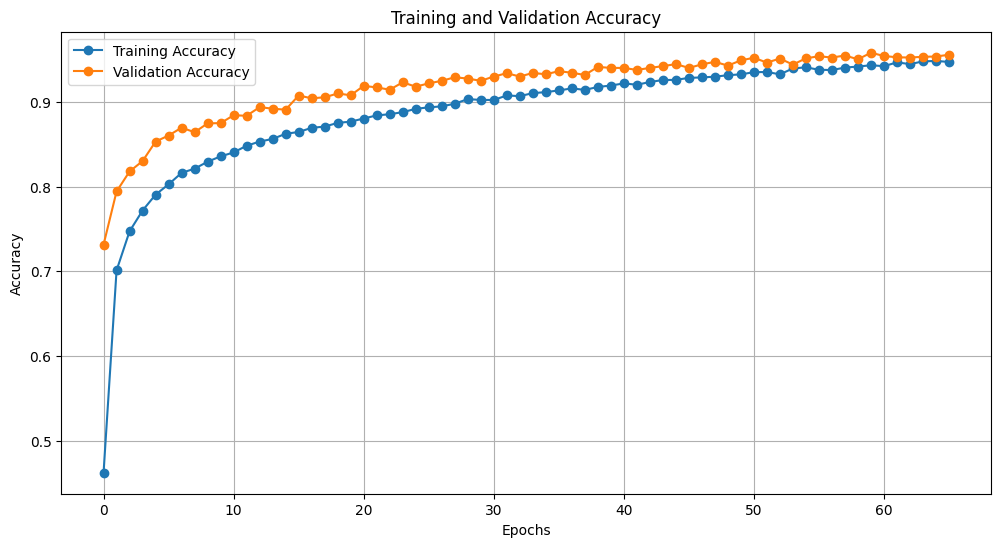

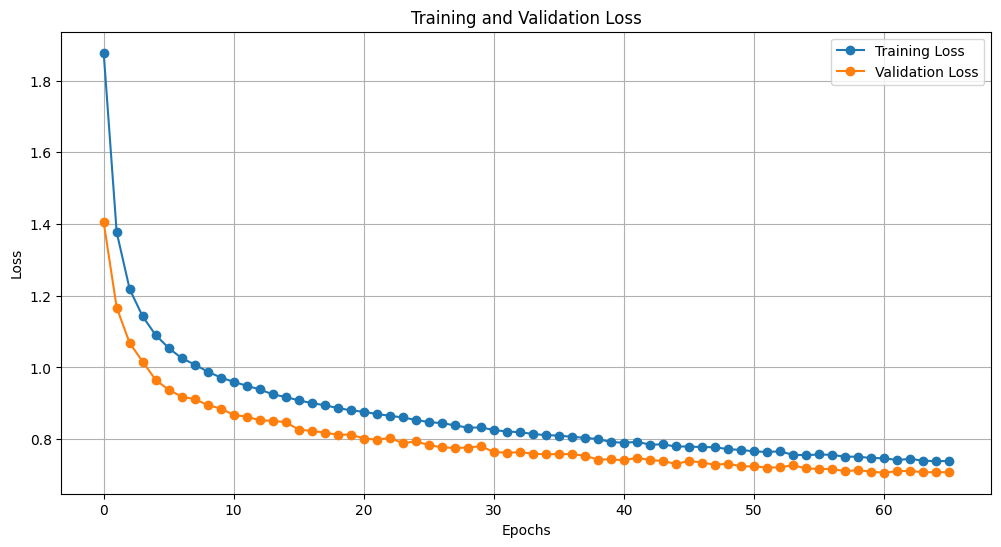

In [26]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history["train_acc"], label="Training Accuracy", marker="o")
plt.plot(history["val_acc"], label="Validation Accuracy", marker="o")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history["train_loss"], label="Training Loss", marker="o")
plt.plot(history["val_loss"], label="Validation Loss", marker="o")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


In [30]:
def evaluate_model(model, data_loader, device):
    """
    Evaluates the accuracy of the model on the given DataLoader.

    Args:
        model: Trained PyTorch model.
        data_loader: DataLoader for the dataset to evaluate.
        device: Device to run the model on ('cpu' or 'cuda').

    Returns:
        accuracy: Accuracy of the model on the dataset.
    """
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Predictions
            predicted = outputs.argmax(dim=1)

            # Count correctly classified samples
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    # Calculate accuracy
    accuracy = correct / total
    return accuracy

# Evaluate the model
true_accuracy = evaluate_model(trained_model, test_loader, device)
print(f"Test Accuracy: {true_accuracy:.4f}")


Test Accuracy: 0.9545


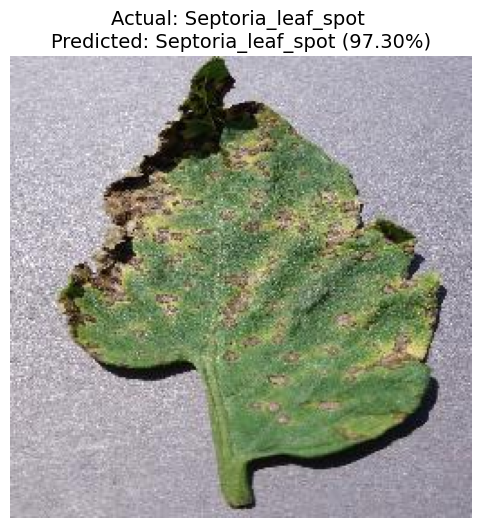

In [31]:
def visualize_prediction(model, data, device, class_names):
    """
    Displays a test image along with its actual and predicted class probabilities.

    Args:
        model: Trained PyTorch model.
        data: A single (image, label) tuple from the dataset or DataLoader.
        device: The device to run the model on ('cpu' or 'cuda').
        class_names: List of class names corresponding to the labels.
    """
    model.eval()  # Set the model to evaluation mode

    # Unpack the image and label
    img, label = data
    img, label = img.to(device), label.to(device)

    # Add batch dimension to the image if needed
    img_batch = img.unsqueeze(0)

    # Predict the class of the image
    with torch.no_grad():
        outputs = model(img_batch)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)

    # Convert the image tensor to a NumPy array for visualization
    img_np = img.cpu().numpy().transpose((1, 2, 0))  # Convert to HWC format
    img_np = np.clip(img_np, 0, 1)  # Ensure pixel values are in range [0, 1]

    # Get actual and predicted class names and probabilities
    actual_class = class_names[label.item()]
    predicted_class = class_names[predicted.item()]
    predicted_prob = probabilities[0, predicted.item()].item() * 100
    
    

    # Plot the image with predicted and actual class
    plt.figure(figsize=(6, 6))
    plt.imshow(img_np)
    plt.title(f"Actual: {actual_class} \nPredicted: {predicted_class} ({predicted_prob:.2f}%)", fontsize=14)
    plt.axis('off')
    plt.show()

# Visualizing a single image from the test_loader
for img, label in test_loader:  # Get one batch of data
    visualize_prediction(trained_model, (img[0], label[0]), device, CLASSES)  # Visualize the first image
    break


In [28]:
#Downloading the model's state_dict
torch.save(trained_model.state_dict(), "/kaggle/working/trained_model.pth")

#Also downloading the full model just in case
torch.save(trained_model, "/kaggle/working/trained_model_complete.pth")
